In [1]:
import os
import time

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

# import tensorflow as tf
# from tensorflow.python.ops.numpy_ops import np_config

import tensorcircuit as tc
from opt_einsum import contract

import jax
from jax import numpy as jnp
from jax import random

import optax

from src.QDDPM_jax import setDiffusionDataOneQubit, QDDPM, HaarSampleGeneration
from src.distance_jax import naturalDistance, WassDistance, sinkhornDistance

rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


# Generate data

In [2]:
def circleYGen(N_train, seed=0):
    # generate random quantum states from RY(\phi)|0>
    # assume uniform distribution
    key = random.PRNGKey(seed)
    phis = random.uniform(key, shape=(N_train,), minval=0, maxval=2*np.pi)
    states = jnp.stack((jnp.cos(phis), jnp.sin(phis)))
    states = jnp.transpose(states)

    return jnp.complex64(states)

In [3]:
n = 1
T = 40
N = 10000

diff_hs = 1.3e-3*jnp.arange(1, T+1)**2
diff_hs

Array([1.3000e-03, 5.2000e-03, 1.1700e-02, 2.0800e-02, 3.2500e-02,
       4.6800e-02, 6.3700e-02, 8.3200e-02, 1.0530e-01, 1.3000e-01,
       1.5730e-01, 1.8720e-01, 2.1970e-01, 2.5480e-01, 2.9250e-01,
       3.3280e-01, 3.7570e-01, 4.2120e-01, 4.6930e-01, 5.2000e-01,
       5.7330e-01, 6.2920e-01, 6.8770e-01, 7.4880e-01, 8.1250e-01,
       8.7880e-01, 9.4770e-01, 1.0192e+00, 1.0933e+00, 1.1700e+00,
       1.2493e+00, 1.3312e+00, 1.4157e+00, 1.5028e+00, 1.5925e+00,
       1.6848e+00, 1.7797e+00, 1.8772e+00, 1.9773e+00, 2.0800e+00],      dtype=float32, weak_type=True)

In [4]:
X = circleYGen(N)

Xout = np.zeros((T + 1, N, 2**n), dtype=np.complex64)
Xout[0] = X
for t in range(1, T + 1):
    Xout[t] = setDiffusionDataOneQubit(X, diff_hs[:t])
    print("Step {}".format(t))

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40


In [5]:
data_path = "./data/circle/n1"
file_name = 'circleYDiff_n1T%d_N%d.npy'%(T, N)
if not os.path.exists(data_path):
    os.makedirs(data_path)

jnp.save(os.path.join(data_path, file_name).replace("\\","/"), Xout)

Text(0.5, 0, '$t$')

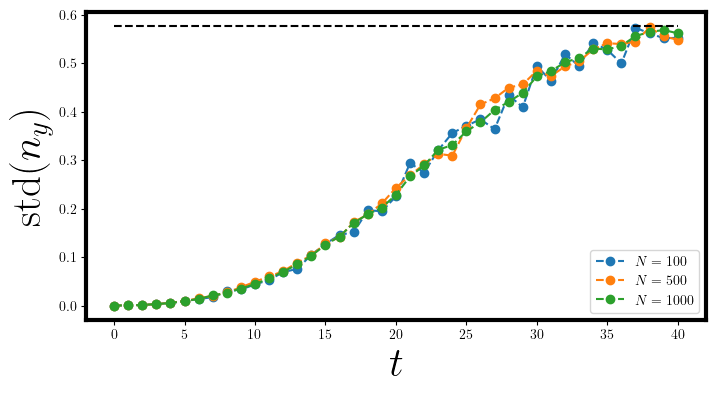

In [6]:
# plot the standard deviation of <Y>
sy = jnp.array([[0,-1j],[1j,0]])
X = jnp.load('data/circle/n1/circleYDiff_n1T%d_N%d.npy'%(T, N))
ys = contract('tmi, ij, tmj->tm', X.conj(), sy, X)

Ns = [100, 500, 1000]
plt.figure(figsize=(8, 4))
for i in range(3):
    idx = random.choice(random.PRNGKey(i), N, shape=(Ns[i], ), replace=False)
    ysample = ys[:,idx]
    plt.plot(range(T+1), jnp.std(ysample, axis=1), 'o--', label=r'$N=%d$'%Ns[i])
plt.plot(range(T+1), 1 / jnp.sqrt(3) * jnp.ones(T+1), '--', c='k')
plt.legend()
plt.ylabel(r'${\rm std}(n_y)$', fontsize=30)
plt.xlabel(r'$t$', fontsize=30)

# Training

In [7]:
def Training_t(model, t, inputs_T, params_tot, epochs, dis_measure='wd'):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    epochs: number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    Ndata = inputs_T.shape[0]

    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    key = random.PRNGKey(np.random.randint(low=0, high=5000))
    params_t = random.normal(key, shape=(2 * 3 * 6,))

    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate = 5e-4)
    opt_state = optimizer.init(params_t)

    if dis_measure == 'nat':
        def loss_func(params_t, input_tplus1, true_data):
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = naturalDistance(output_t, true_data)
            
            return loss

    elif dis_measure == 'wd':
        def loss_func(params_t, input_tplus1, true_data):
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = sinkhornDistance(output_t, true_data, reg=0.01)
        
            return loss
    
    loss_func_vg = jax.jit(jax.value_and_grad(loss_func))
    #@partial(jax.jit, static_argnums=(2, ))
    def update(params_t, input_tplus1, true_data, opt_state):
        loss_value, grads = loss_func_vg(params_t, input_tplus1, true_data)
        # print(grads.shape)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_t)
        new_params_t = optax.apply_updates(params_t, updates)

        return new_params_t, new_opt_state, loss_value

    t0 = time.time()
    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        params_t, opt_state, loss_value = update(params_t, input_tplus1, true_data, opt_state)
        
        if step % 100 == 0:
            print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(step, loss_value, time.time() - t0))
        
        loss_hist.append(loss_value) # record the current loss

    return params_t, loss_hist


In [8]:
n, na = 1, 2
T = 40
L = 6

Ndata = 500
epochs = 1201

inputs_T = HaarSampleGeneration(Ndata, seed=22)
states_diff = jnp.load('data/circle/n1/circleYDiff_n1T%d_N10000.npy' %T)

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)
params_tot = jnp.zeros((T, 2*(n + na)*L))

params, loss = Training_t(model, T - 1, inputs_T, params_tot, epochs, 'wd')

Step 0, loss: 0.0690689, time elapsed: 2.6582 seconds
Step 100, loss: 0.0564850, time elapsed: 19.9366 seconds
Step 200, loss: 0.0523906, time elapsed: 34.4944 seconds
Step 300, loss: 0.0494950, time elapsed: 48.4517 seconds
Step 400, loss: 0.0510584, time elapsed: 62.3373 seconds
Step 500, loss: 0.0506866, time elapsed: 76.0471 seconds
Step 600, loss: 0.0482453, time elapsed: 89.7168 seconds
Step 700, loss: 0.0489737, time elapsed: 103.8095 seconds
Step 800, loss: 0.0484609, time elapsed: 117.5828 seconds
Step 900, loss: 0.0494450, time elapsed: 131.5146 seconds
Step 1000, loss: 0.0492266, time elapsed: 144.8324 seconds
Step 1100, loss: 0.0487710, time elapsed: 158.5610 seconds
Step 1200, loss: 0.0479232, time elapsed: 172.2828 seconds


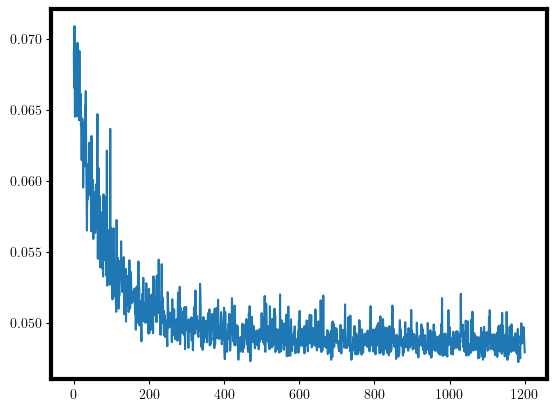

In [9]:
plt.plot(jnp.stack(loss))